Saving descargar.png to descargar.png


/tmp/ipython-input-3899494905.py:10: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  sinang = np.linalg.norm(np.cross(v1, v2))


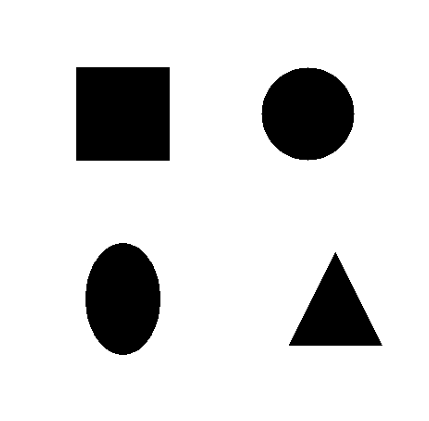

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
from google.colab import files
from IPython.display import display, Image as IPyImage

def angle_between(v1, v2):
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    angle = np.arctan2(sinang, cosang)
    return np.degrees(angle)

def classify_shape(approx, area, peri, w, h):
    nv = len(approx)
    ar = w / float(h)
    circularity = 4 * np.pi * area / (peri * peri) if peri != 0 else 0
    box_area = w * h

    # Círculo: circularidad
    if circularity > 0.85 and area / box_area > 0.7:
        return "Circle"
    # Triángulo
    elif nv == 3:
        return "Triangle"
    # Cuadrado: 4 vértices, aspect ratio ~1, ángulos cercanos a 90°
    elif nv == 4:
        pts = approx.reshape(-1, 2)
        angles = []
        for i in range(4):
            p0 = pts[i]
            p1 = pts[(i+1)%4]
            p2 = pts[(i+2)%4]
            v1 = p0 - p1
            v2 = p2 - p1
            ang = angle_between(v1, v2)
            angles.append(ang)
        if np.all([80 < a < 100 for a in angles]) and 0.95 < ar < 1.05 and area/box_area > 0.80:
            return "Square"
        elif np.all([80 < a < 100 for a in angles]) and area/box_area < 0.80:
            return "Rectangle"
        else:
            return "Polygon"
    # Polígonos regulares
    elif nv == 5:
        return "Pentagon"
    elif nv == 6:
        return "Hexagon"
    elif nv == 8:
        return "Octagon"
    else:
        return "Polygon"

uploaded = files.upload()
img_path = next(iter(uploaded))
img = cv2.imread(img_path)

# Padding para asegurar que los contornos no toquen el borde
img_padded = cv2.copyMakeBorder(img, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=[255,255,255])
img_gray = cv2.cvtColor(img_padded, cv2.COLOR_BGR2GRAY)

frames = [Image.fromarray(cv2.cvtColor(img_padded, cv2.COLOR_BGR2RGB))]
_, thresh_fixed = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
frames.append(Image.fromarray(thresh_fixed))
thresh_adapt = cv2.adaptiveThreshold(
    img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)
frames.append(Image.fromarray(thresh_adapt))

contours, hierarchy = cv2.findContours(
    thresh_adapt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

areas = [cv2.contourArea(c) for c in contours]
max_area = max(areas)
min_area = 100  # ¡Asegúrate que sea pequeño!

img_shapes = img_padded.copy()
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < min_area:
        continue
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.015 * peri, True)
    x, y, w, h = cv2.boundingRect(cnt)
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = x + w//2, y + h//2
    shape_type = classify_shape(approx, area, peri, w, h)
    # Dibuja
    cv2.drawContours(img_shapes, [approx], -1, (0,255,0), 2)
    cv2.rectangle(img_shapes, (x, y), (x + w, y + h), (255, 0, 255), 2)
    cv2.circle(img_shapes, (cx, cy), 4, (0,0,255), -1)
    cv2.putText(img_shapes, shape_type, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0,0,255), 2)
    cv2.putText(img_shapes, f"A:{int(area)}", (x, y+h+22), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (128,0,128), 2)
    cv2.putText(img_shapes, f"P:{int(peri)}", (x, y+h+42), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (128,0,128), 2)

frames.append(Image.fromarray(cv2.cvtColor(img_shapes, cv2.COLOR_BGR2RGB)))

gif_bytes = BytesIO()
frames[0].save(
    gif_bytes,
    format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=1000,
    loop=0
)
gif_bytes.seek(0)

display(IPyImage(data=gif_bytes.getvalue()))
with open('shapes_result.gif', 'wb') as f:
    f.write(gif_bytes.getvalue())
files.download('shapes_result.gif')